# Milestone 2: Data exploration 

For the purpose of the Milstone 2, this notebook aims to cover the data exploration needed to define our project.

In [1]:
# Library
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset 
from src.scripts.load_and_save import load_data_direct

df_bindingDB = load_data_direct()
df_bindingDB.head()


/home/sallinen/Programmation/ada-2024-project-laambada/src/scripts/load_and_save.py:18: DtypeWarning: Columns (8,9,10,11,12,13,15,17,18,20,21,22,23,27,28,32,33,35,36,45,46,47,48,50,51,52,53,54,55,57,58,59,60,62,63,64,65,66,67,69,70,71,72,74,75,76,77,78,79,81,82,83,86,87,88,89,90,91,93,94,95,98,99,100,101,102,103,105,106,107,110,111,112,113,114,115,117,118,119,122,123,124,125,126,127,129,130,131,134,135,136,137,138,139,146,147,148,149,150,151,158,159,160,161,162,163,170,172,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, sep='\t', on_bad_lines='skip')


,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Recommended Name of Target Chain.12,UniProt (SwissProt) Entry Name of Target Chain.12,UniProt (SwissProt) Primary ID of Target Chain.12,UniProt (SwissProt) Secondary ID(s) of Target Chain.12,UniProt (SwissProt) Alternative ID(s) of Target Chain.12,UniProt (TrEMBL) Submitted Name of Target Chain.12,UniProt (TrEMBL) Entry Name of Target Chain.12,UniProt (TrEMBL) Primary ID of Target Chain.12,UniProt (TrEMBL) Secondary ID(s) of Target Chain.12,UniProt (TrEMBL) Alternative ID(s) of Target Chain.12
0,1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,InChI=1S/C31H42N2O7/c34-27(35)17-9-3-11-19-32-...,XGEGDSLAQZJGCW-HHGOQMMWSA-N,608734,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,InChI=1S/C31H34N6O3/c38-29-27(17-23-9-3-1-4-10...,UZLMEAPBHYEHAC-UNTBESQGSA-N,22,"(4R,5S,6S,7R)-4,7-dibenzyl-5,6-dihydroxy-1,3-b...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,InChI=1S/C29H34N4O3/c34-27-25(16-21-8-3-1-4-9-...,HYNYUFZPPJMPOB-UTWJFGBXSA-N,23,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,InChI=1S/C29H40N2O4/c32-18-10-2-1-9-17-30-25(1...,YXVAZXDWVZTGGD-VIJSPRBVSA-N,24,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,InChI=1S/C28H38N2O4/c31-17-9-3-8-16-29-24(18-2...,WWTSWTPNILRSJX-XDZXDJIYSA-N,25,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_bindingDB.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927364 entries, 0 to 2927363
Data columns (total 194 columns):
 #    Column                                                                Non-Null Count    Dtype  
---   ------                                                                --------------    -----  
 0    BindingDB Reactant_set_id                                             2927364 non-null  int64  
 1    Ligand SMILES                                                         2927364 non-null  object 
 2    Ligand InChI                                                          2802975 non-null  object 
 3    Ligand InChI Key                                                      2802975 non-null  object 
 4    BindingDB MonomerID                                                   2927364 non-null  int64  
 5    BindingDB Ligand Name                                                 2927364 non-null  object 
 6    Target Name                                                     

## 1. First Glimps Of The Dataset

In [4]:
print(f'The dataset is {df_bindingDB.shape[0]} and contains {df_bindingDB.shape[1]} columns')

The dataset is 2927364 and contains 194 columns


We can split the colmuns in 3 categories depending on the kind of information that they provide: 
- ligand information : columns from 0 to 8
- reaction information : columns from 8 to 16
- targets information : colmuns from 16 to 194

In [5]:
# Data Exploration: Due to the huge size of the dataset we will drive our analysis on a subset
df_subset = df_bindingDB.loc[100: 100040].copy()

In [6]:
# Util functions to explore the columns 
from src.utils.exploration_and_clean import explore_column, quick_check_column, clean_metrics

### 1.1 Ligand information

In [7]:
# This part concerne the columns form 0 to 
df_subset.columns[0:8]

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource'],
      dtype='object')

In [8]:
for i in range(8) :
    explore_column(df_subset, i)
    print()

# BindingDB Reactant_set_id
0 nan values (0.0%)
99940 unique values

# Ligand SMILES
0 nan values (0.0%)
51484 unique values

# Ligand InChI
3 nan values (0.0%)
51478 unique values

# Ligand InChI Key
3 nan values (0.0%)
51478 unique values

# BindingDB MonomerID
0 nan values (0.0%)
51497 unique values

# BindingDB Ligand Name
0 nan values (0.0%)
51496 unique values

# Target Name
0 nan values (0.0%)
1225 unique values

# Target Source Organism According to Curator or DataSource
16295 nan values (16.3%)
119 unique values



##### *Rdkit*
https://www.rdkit.org \
Rdkit is a nice open-source toolkit for cheminformatics. It allow to extract the chemical properties from the SMILES of the ligand.\
Using it we will manage to extract the molecular weight, the composition, the hydrophobicity and the charges. \
/!\ Don't forget to install it, if it's not already done!

In [9]:
# Ligan analysis 
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments, Draw

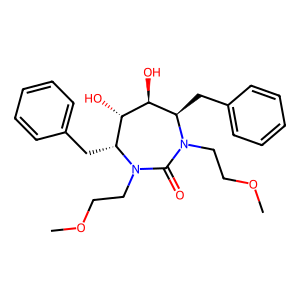

In [10]:
# Example molecule
sample_molecule = Chem.MolFromSmiles(df_subset["Ligand SMILES"].iloc[0])
Draw.MolToImage(sample_molecule)

In [11]:
# Rdkit Description 
sample_molecule = Chem.MolFromSmiles(df_subset["Ligand SMILES"].iloc[0])

print("Molecular weight of the first molecule: ", Descriptors.MolWt(sample_molecule))
print("Number of valence electrons of the first molecule: ", Descriptors.NumValenceElectrons(sample_molecule))
Chem.Descriptors.CalcMolDescriptors(sample_molecule, missingVal=None, silent=True)

Molecular weight of the first molecule:  442.5560000000003
Number of valence electrons of the first molecule:  174


{'MaxAbsEStateIndex': 13.768109095490047,
 'MaxEStateIndex': 13.768109095490047,
 'MinAbsEStateIndex': 0.22540532879818564,
 'MinEStateIndex': -1.1136394557823135,
 'qed': 0.5879309171190104,
 'SPS': 23.9375,
 'MolWt': 442.5560000000003,
 'HeavyAtomMolWt': 408.2840000000002,
 'ExactMolWt': 442.24677218799997,
 'NumValenceElectrons': 174,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.32037211047159864,
 'MinPartialCharge': -0.3881707599697216,
 'MaxAbsPartialCharge': 0.3881707599697216,
 'MinAbsPartialCharge': 0.32037211047159864,
 'FpDensityMorgan1': 0.71875,
 'FpDensityMorgan2': 1.09375,
 'FpDensityMorgan3': 1.4375,
 'BCUT2D_MWHI': 16.46555143542942,
 'BCUT2D_MWLOW': 9.908609888363157,
 'BCUT2D_CHGHI': 2.454937597337904,
 'BCUT2D_CHGLO': -2.350051412825495,
 'BCUT2D_LOGPHI': 2.26784487219309,
 'BCUT2D_LOGPLOW': -2.5230527797710303,
 'BCUT2D_MRHI': 5.7581836802704425,
 'BCUT2D_MRLOW': -0.041914980719869245,
 'AvgIpc': 2.882665522785858,
 'BalabanJ': 1.9734492627420277,
 'BertzCT': 

In [12]:
# Lets see if we can use it in a feasable time
# To save executions time
execution_times = []

smiles_to_molecules = []
for smiles in df_subset['Ligand SMILES']:
    start_time = time.time()
    molecule = Chem.MolFromSmiles(smiles) 
    smiles_to_molecules.append(molecule)
    end_time = time.time()
    execution_times.append(end_time - start_time)

# statistics for time
mean_time = np.mean(execution_times)
std_time = np.std(execution_times)

print(f"Mean execution time: {mean_time} seconds")
print(f"Standard deviation: {std_time} seconds")
print(f"Estimation for the full dataset: {round(len(df_bindingDB)*mean_time/60)} minutes")

df_subset['RDKIT Molecules'] = smiles_to_molecules

print(f"Number of molecules not processed by rdkit: {df_subset['RDKIT Molecules'].isna().sum()} out of {len(df_subset)} ligands")
# Delete these rows
df_subset = df_subset.dropna(subset=['RDKIT Molecules'])
print(len(df_subset))

[00:01:27] non-ring atom 28 marked aromatic
[00:01:27] non-ring atom 28 marked aromatic
[00:01:27] Explicit valence for atom # 28 N, 4, is greater than permitted
[00:01:30] Explicit valence for atom # 12 N, 4, is greater than permitted
[00:01:30] Explicit valence for atom # 12 N, 4, is greater than permitted
[00:01:34] Explicit valence for atom # 17 O, 3, is greater than permitted
[00:01:34] Explicit valence for atom # 16 O, 3, is greater than permitted
[00:01:34] Explicit valence for atom # 16 O, 3, is greater than permitted
[00:01:34] Explicit valence for atom # 17 O, 3, is greater than permitted
[00:01:34] Explicit valence for atom # 16 O, 3, is greater than permitted
[00:01:34] Explicit valence for atom # 16 O, 3, is greater than permitted


Mean execution time: 0.00013908805913582885 seconds
Standard deviation: 0.00019783403961863287 seconds
Estimation for the full dataset: 7 minutes
Number of molecules not processed by rdkit: 11 out of 99941 ligands
99930


**Conclusion** \
Rdkit allow us to have more information about the ligans and caraterize them better, apparently most of the data are compatible with the tool, but it will require an additionnal selection of the sample that we will use.

### 1.2 Reaction information 

In [13]:
# The affinity measurement are not to heavy to handle lets do the analysis over the all dataset
reaction_metrics = df_bindingDB.iloc[:, 8:16].copy()

In [14]:
for i in range(reaction_metrics.shape[1]) :
    explore_column(reaction_metrics, i)
    print()

# Ki (nM)
2334353 nan values (79.74%)
27708 unique values

# IC50 (nM)
969108 nan values (33.11%)
59231 unique values

# Kd (nM)
2816220 nan values (96.2%)
8195 unique values

# EC50 (nM)
2659490 nan values (90.85%)
23388 unique values

# kon (M-1-s-1)
2926358 nan values (99.97%)
662 unique values

# koff (s-1)
2926378 nan values (99.97%)
578 unique values

# pH
2712103 nan values (92.65%)
88 unique values

# Temp (C)
2726459 nan values (93.14%)
59 unique values



In [15]:
# Among the metrics some of them are string, float : lets clean them 
for col in reaction_metrics.columns[:-2] :
    reaction_metrics[col] = clean_metrics(reaction_metrics[col])
    # Check if its only float: 
    for metric in reaction_metrics[col].unique():
        if type(metric) != np.float64 :
            print(col, type(metric))


In [16]:
# If we remove all the nan value at this step we will not have any metrics left 
print('Sample size with no nan value :', reaction_metrics.dropna().shape[0])

# But lets see how much data we have for each 
print('Individually we have : ')
for col in reaction_metrics.columns :
    col_no_nan = reaction_metrics[col].dropna()
    print(col, col_no_nan.shape[0])

Sample size with no nan value : 0
Individually we have : 
Ki (nM) 506885
IC50 (nM) 1551707
Kd (nM) 53840
EC50 (nM) 195113
kon (M-1-s-1) 83
koff (s-1) 46
pH 215261
Temp (C) 200905


Number of sample with pH information 215261


Text(0.5, 1.0, 'pH distribution in logscale')

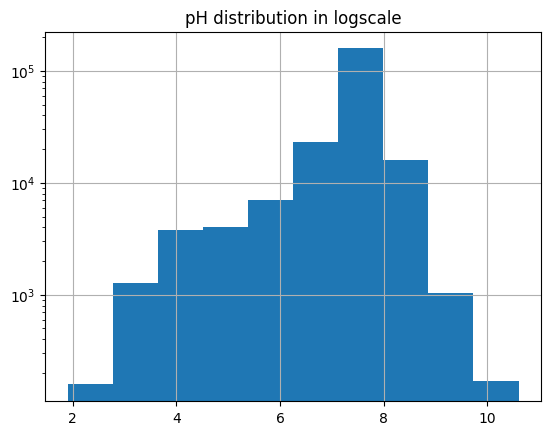

In [17]:
# lets check the pH information
nb = reaction_metrics['pH'].dropna().shape[0]
print('Number of sample with pH information', nb)

reaction_metrics['pH'].dropna().hist(log=True)
plt.title('pH distribution in logscale')

Number of sample with temperature information 200905


Text(0.5, 1.0, 'Temperature distribution in logscale')

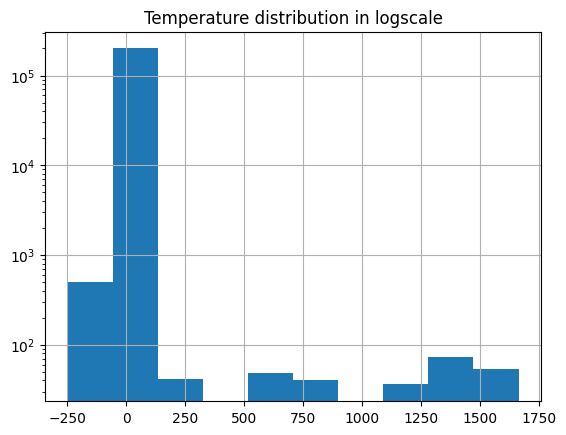

In [18]:
# lets check the temperature information
nb = reaction_metrics['Temp (C)'].dropna().shape[0]
print('Number of sample with temperature information', nb)

# Need to be clean (remove C and to float)
reaction_metrics['Temp (C)'] = clean_metrics(reaction_metrics['Temp (C)'])

reaction_metrics['Temp (C)'].dropna().hist(log=True)
plt.title('Temperature distribution in logscale')

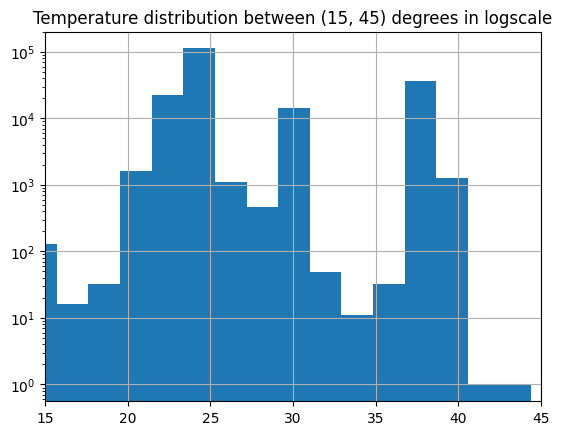

In [19]:
# Closer look to the physiolocial level
reaction_metrics['Temp (C)'].dropna().hist(log=True, bins=1000)
plt.xlim(15,45)
plt.title('Temperature distribution between (15, 45) degrees in logscale')
plt.show()

*REMARQUES:*
For pH and Temperature, lot of value around the human physiological Temp ~ 37 °C and pH =7 and in vitro experiments Temp ~25 °C. Can be intresting to affine our analysis. But not enought data to incorporate it to a model.

### 1.3 Target information

In [20]:
# Column list 
df_subset[16:len(df_subset.columns)].columns 

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource', 'Ki (nM)',
       'IC50 (nM)',
       ...
       'UniProt (SwissProt) Entry Name of Target Chain.12',
       'UniProt (SwissProt) Primary ID of Target Chain.12',
       'UniProt (SwissProt) Secondary ID(s) of Target Chain.12',
       'UniProt (SwissProt) Alternative ID(s) of Target Chain.12',
       'UniProt (TrEMBL) Submitted Name of Target Chain.12',
       'UniProt (TrEMBL) Entry Name of Target Chain.12',
       'UniProt (TrEMBL) Primary ID of Target Chain.12',
       'UniProt (TrEMBL) Secondary ID(s) of Target Chain.12',
       'UniProt (TrEMBL) Alternative ID(s) of Target Chain.12',
       'RDKIT Molecules'],
      dtype='object', length=195)

In [21]:
# Print the description for all 
for i in range(16, len(df_subset.columns)) :
    explore_column(df_subset, i)
    print()

# Curation/DataSource
0 nan values (0.0%)
3 unique values
['Curated from the literature by BindingDB' 'US Patent' 'PubChem']

# Article DOI
39389 nan values (39.42%)
1567 unique values

# BindingDB Entry DOI
0 nan values (0.0%)
2158 unique values

# PMID
39722 nan values (39.75%)
1562 unique values

# PubChem AID
294 nan values (0.29%)
2165 unique values

# Patent Number
99569 nan values (99.64%)
49 unique values

# Authors
0 nan values (0.0%)
1614 unique values

# Institution
0 nan values (0.0%)
496 unique values

# Link to Ligand in BindingDB
0 nan values (0.0%)
51492 unique values

# Link to Target in BindingDB
0 nan values (0.0%)
1450 unique values

# Link to Ligand-Target Pair in BindingDB
0 nan values (0.0%)
87660 unique values

# Ligand HET ID in PDB
92133 nan values (92.2%)
1817 unique values

# PDB ID(s) for Ligand-Target Complex
91827 nan values (91.89%)
1986 unique values

# PubChem CID
0 nan values (0.0%)
51459 unique values

# PubChem SID
0 nan values (0.0%)
51492 unique v

# Number of Protein Chains in Target (>1 implies a multichain complex)
0 nan values (0.0%)
4 unique values
[1 2 3 4]


<Axes: title={'center': 'Number of Protein Chains in Target'}, ylabel='Frequency'>

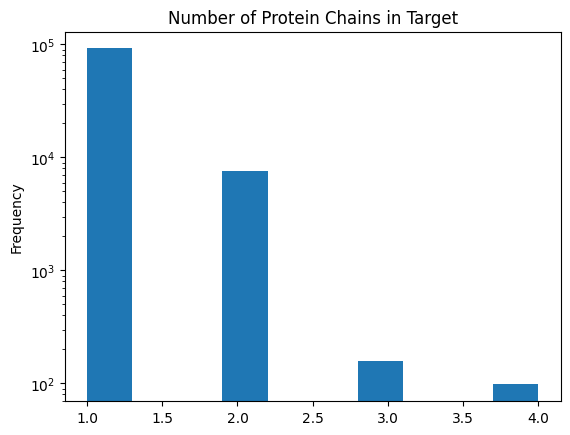

In [22]:
# Closer loop into the multi chain
i = 37
explore_column(df_subset, i)

column = df_subset[df_subset.columns[i]]
column.plot(kind='hist', logy=True, title="Number of Protein Chains in Target")

<Axes: xlabel='Target Source Organism According to Curator or DataSource'>

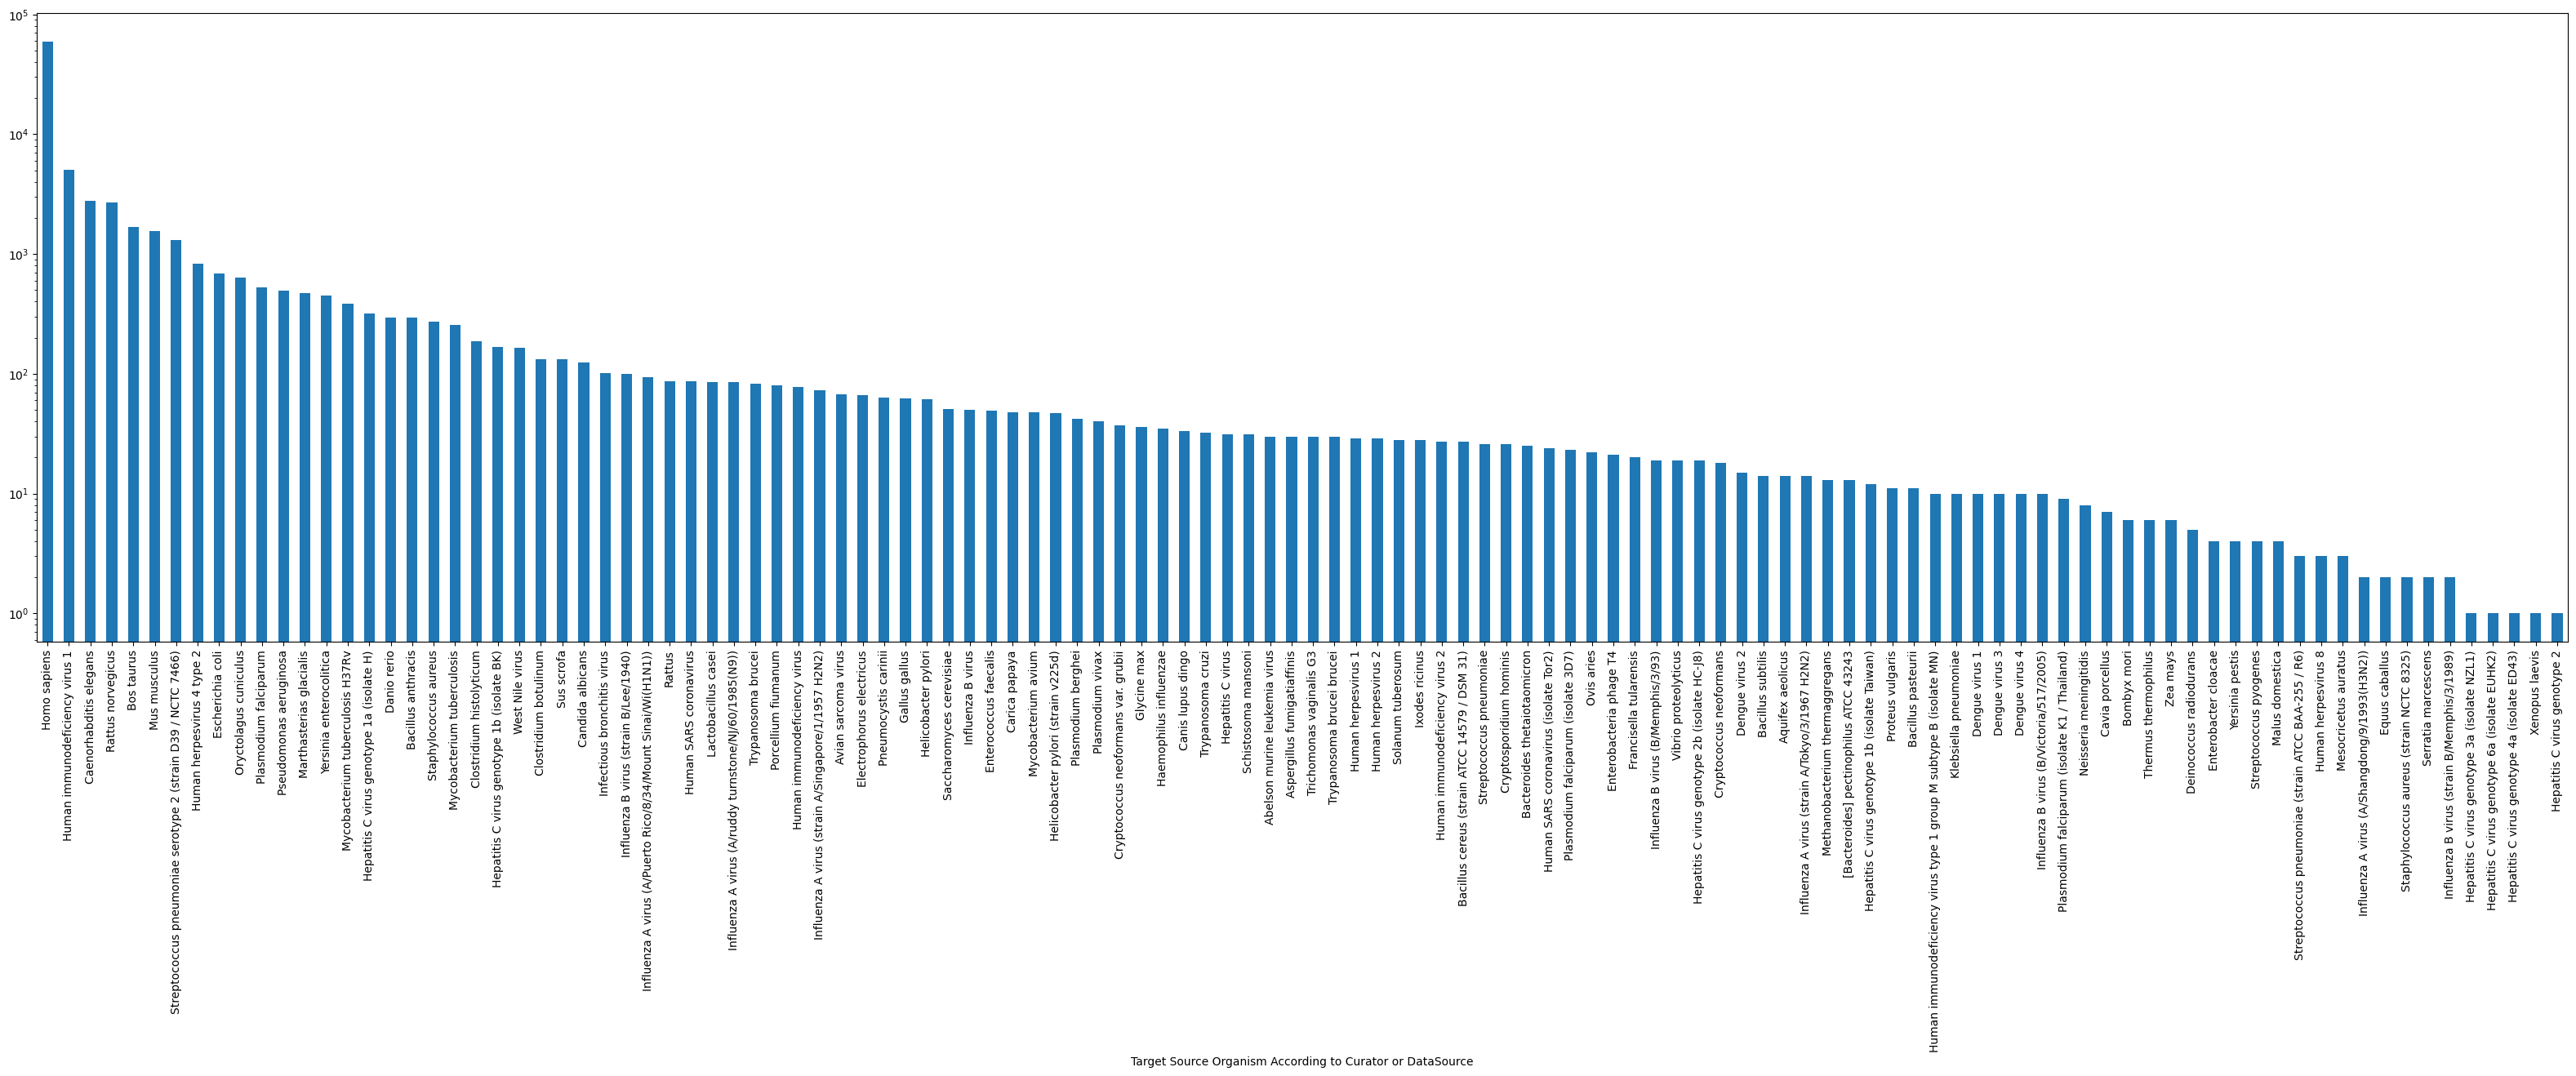

In [23]:
# Host organism 
fig, ax = plt.subplots(figsize=(10, 5))
df_subset["Target Source Organism According to Curator or DataSource"].value_counts().plot(kind="bar", logy=True, figsize=(40, 10))

## 2. Data cleaning

### 1. Metric selection

In [24]:
# We don't have all the metrics for 1 sample but we do have sample with multiple metrics
commun_pairs= pd.DataFrame(index = reaction_metrics.columns, columns=reaction_metrics.columns)

from itertools import combinations

for i, j in combinations(reaction_metrics.columns, 2) : 
    commun_pairs.at[i, j]= reaction_metrics[[i, j]].dropna().shape[0]


# put on the diagonal the number of sample for 1 metric
for col in reaction_metrics.columns :
    commun_pairs.at[col, col] = reaction_metrics[col].dropna().shape[0]

commun_pairs

,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),pH,Temp (C)
Ki (nM),506885,2857,13,787,0,1,34971,30354
IC50 (nM),NaN,1551707,110,1218,0,0,142514,129527
Kd (nM),NaN,NaN,53840,11,0,0,1839,1185
EC50 (nM),NaN,NaN,NaN,195113,0,0,6423,11667
kon (M-1-s-1),NaN,NaN,NaN,NaN,83,0,0,0
koff (s-1),NaN,NaN,NaN,NaN,NaN,46,11,8
pH,NaN,NaN,NaN,NaN,NaN,NaN,215261,129990
Temp (C),NaN,NaN,NaN,NaN,NaN,NaN,NaN,200905


In [25]:
# Let's try the trio 
trio = pd.DataFrame()

for i, j, k in combinations(reaction_metrics.columns, 3) : 
    nb = reaction_metrics[[i, j, k]].dropna().shape[0]
    
    if nb != 0 : 
        df = pd.DataFrame([[i, j, k, nb]])
        
        trio = pd.concat([trio, df])
        
trio.columns = [1, 2, 3, 'number']
trio

,1,2,3,number
0,Ki (nM),IC50 (nM),Kd (nM),8
0,Ki (nM),IC50 (nM),EC50 (nM),71
0,Ki (nM),IC50 (nM),pH,1443
0,Ki (nM),IC50 (nM),Temp (C),1399
0,Ki (nM),Kd (nM),pH,8
0,Ki (nM),Kd (nM),Temp (C),8
0,Ki (nM),EC50 (nM),pH,462
0,Ki (nM),EC50 (nM),Temp (C),397
0,Ki (nM),pH,Temp (C),22004
0,IC50 (nM),Kd (nM),pH,66


**Conclusion** \
Juste by looking at the number of data, we can say that a very nice choice could be either IC50 (1540239 samples) or Ki (506521 samples). Additionnaly both have information about temperature and pH : Ki : 22004 sample, IC50 84647 which can allow us to push further the analysis. \

Lets give some chemical theory to see what does this metrics give us about the reaction caracterization. \

*IC50*
- Half maximal inhibitory concentration,  effectiveness of a substance in inhibiting. 
- Concentration of a ligan that is required to inhibit 50% of a target's activity in a particular assay.
- Quantitative measure of how effective an inhibitor is.

*Ki*
- Inhibition constant, concentration of an inhibitor needed to decrease the enzyme's activity to half of its maximum rate when substrate concentration is high.
- Measures the binding affinity between the enzyme and the inhibitor (lower Ki values indicate stronger inhibition)
- Used in Michaelis-Menten kinetics to understand competitive, non-competitive, and uncompetitive inhibition.


*Relationship IC50 - Ki* : IC50 used in practical applications to assess inhibitor strength, depends on the concentrations. Ki is more specific to the interaction between the enzyme and the inhibitor. 


We will go for Ki that seems more suited to study the overall structrual properties associated to ligan-target binding.

In [26]:
# We choose Ki, lets select the samples in the full dataset

# put the clean Ki in the full dataset
df_bindingDB['Ki (nM)'] = reaction_metrics['Ki (nM)']

# take only the non nan value
df_bindingDB = df_bindingDB.dropna(subset=['Ki (nM)']) 

In [27]:
df_bindingDB.shape

(506885, 194)

### 2. Let's look for a suitable protein family to study
**Step 1. Match targets to their families. We made a choice to use PANTHER classification, although other classifications exist too.**

In [28]:

import sys
sys.path.append('./src/utils')
from retrieve_family import retrieve_family

uniprot_ids = df_bindingDB["UniProt (SwissProt) Entry Name of Target Chain"].unique()
family_dict = await retrieve_family(uniprot_ids)

# Set of unique protein families
families = set()
for key in family_dict:
    families.update(family_dict[key])

# Dictionary with the protein families as keys and the UniProt names as values
family_dict_2 = {family: [] for family in families}
for key in family_dict:
    for family in family_dict[key]:
        if key not in family_dict_2[family]:
            family_dict_2[family].append(key)

print(f"We were able to retrieve {len(families)} unique protein families")

100%|██████████| 2764/2764 [00:18<00:00, 150.37it/s]

We were able to retrieve 3645 unique protein families


**Step 2. Now that each target is mapped to its families, let's select families with adequate number of targets.**

In [29]:
import collections

# Count the number of proteins in each family, don't count families with less than n proteins
n = 5
counter = collections.Counter({k: len(v) for k, v in family_dict_2.items() if len(v) >= n})
counter.most_common(10)

[('UNCHARACTERIZED', 157),
 ('ADRENERGIC RECEPTOR-RELATED G-PROTEIN COUPLED RECEPTOR', 108),
 ('G-PROTEIN COUPLED RECEPTOR', 79),
 ('5-HYDROXYTRYPTAMINE RECEPTOR', 76),
 ('TYROSINE-PROTEIN KINASE RECEPTOR', 73),
 ('-', 72),
 ('SERINE/THREONINE-PROTEIN KINASE', 69),
 ('RIBOSOMAL PROTEIN S6 KINASE', 64),
 ('NUCLEAR HORMONE RECEPTOR', 61),
 ('NEUROTRANSMITTER GATED ION CHANNEL', 61)]

Let's filter out some families.

In [30]:
# Drop if family is "-" or "UNCHARACTERIZED"
del counter["-"]
del counter["UNCHARACTERIZED"]
# Only keep families if they are in the counter
family_dict_2 = {k: v for k, v in family_dict_2.items() if k in counter.keys()}
# Only keep proteins if they are in family_dict_2
ids = set()
for key in family_dict_2:
    ids.update(family_dict_2[key])
family_dict = {k: v for k, v in family_dict.items() if k in ids}

In [31]:
df_bindingDB_filtered = df_bindingDB[df_bindingDB['UniProt (SwissProt) Entry Name of Target Chain'].isin(family_dict.keys())]

**Step 3. We would need tagets with enough ligands.**

Let's count ligands in each family.

In [32]:
summary_families = pd.DataFrame.from_dict(counter, orient='index', columns=['Number of targets'])
grouped = df_bindingDB_filtered.groupby('UniProt (SwissProt) Entry Name of Target Chain').count()["Ki (nM)"]
# Discard counts lower than threshold
# threshold = 1000
# grouped = grouped[grouped > threshold]
ligands_count = collections.Counter()
for target in family_dict.keys():
    for family in family_dict[target]:
        try:
            ligands_count[family] += grouped[target]
        except KeyError:
            pass
summary_families["Number of ligands"] = [ligands_count[family] for family in summary_families.index]


In [33]:
summary_families["Average ligands per target"] = summary_families["Number of ligands"] / summary_families["Number of targets"]
summary_families["Average ligands per target"] = summary_families["Average ligands per target"].round(2)
summary_families = summary_families.sort_values(by="Average ligands per target", ascending=False)

In [34]:
summary_families.head(15)

,Number of targets,Number of ligands,Average ligands per target
HISTAMINE RECEPTOR-RELATED G-PROTEIN COUPLED RECEPTOR,5,38502,7700.40
CB1 CANNABINOID RECEPTOR-INTERACTING PROTEIN 1,7,52604,7514.86
REGULATOR OF G PROTEIN SIGNALING,5,27482,5496.40
TYROSINE-PROTEIN KINASE HOPSCOTCH,9,30354,3372.67
"FAM11A, B PROTEIN",5,15969,3193.80
PERIPHERAL-TYPE BENZODIAZEPINE RECEPTOR,5,14317,2863.40
PALMITOYLTRANSFERASE ZDHHC16,6,16510,2751.67
PITUITARY HOMEOBOX HOMOLOG PTX1,6,16042,2673.67
CHLORIDE INTRACELLULAR CHANNEL PROTEIN 6-RELATED,13,33685,2591.15
INTERFERON/INTERLEUKIN RECEPTOR,7,17425,2489.29


**Step 4. Zoom on suitable candidates.**

Let's look at our winner, the `TYROSINE-PROTEIN KINASE HOPSCOTCH` family! At this stage, we used a combination of data balance considerations, personal preferences and biological knowledge to select a family with a manageable amount of targets and a considerable amount of ligands per target.

In [35]:
for target in family_dict_2["TYROSINE-PROTEIN KINASE HOPSCOTCH"]:
    if target in grouped:
        print(f"{target} has {grouped[target]} ligands")

JAK3_HUMAN has 1797 ligands
JAK2_HUMAN has 3698 ligands
JAK1_HUMAN has 3817 ligands
TYK2_HUMAN has 1899 ligands
CCR5_HUMAN has 213 ligands
TEC_HUMAN has 2 ligands
CCR5_MOUSE has 51 ligands
PDE4A_HUMAN has 94 ligands
MERTK_HUMAN has 10 ligands


### 3. Ligand selection

In [36]:
# We only keep the ligand that are rdkit compatible 
# Liste pour stocker les temps d'exécution
execution_times = []

smiles_to_molecules = []
for smiles in df_bindingDB['Ligand SMILES']:
    start_time = time.time()
    molecule = Chem.MolFromSmiles(smiles) 
    smiles_to_molecules.append(molecule)
    end_time = time.time()
    execution_times.append(end_time - start_time)

# Calculer les statistiques
mean_time = np.mean(execution_times)
std_time = np.std(execution_times)

print(f"Mean execution time: {mean_time} seconds")
print(f"Standard deviation: {std_time} seconds")
print(f"Estimation for the full dataset: {round(len(df_bindingDB)*mean_time/60)} minutes")

df_bindingDB['RDKIT Molecules'] = smiles_to_molecules

[00:02:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
[00:02:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16
[00:02:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
[00:02:44] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:02:45] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[00:02:45] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[00:02:45] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[00:02:45] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[00:02:45] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[00:02:45] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[00:02:45] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[00:02:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[00:02:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[00:02:46] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 17 18 19 30 31 32
[00:02:46] Can't kekulize mol.  Unkekuliz

Mean execution time: 0.00021863789995234253 seconds
Standard deviation: 0.00043971936636622467 seconds
Estimation for the full dataset: 2 minutes


## 3. Chemical characterization

### 1. Characterization of all the ligands of the family

Mean execution time: 0.00019317503754902044 seconds
Standard deviation: 0.0004070111560072761 seconds
Estimation for the full dataset: 2 minutes


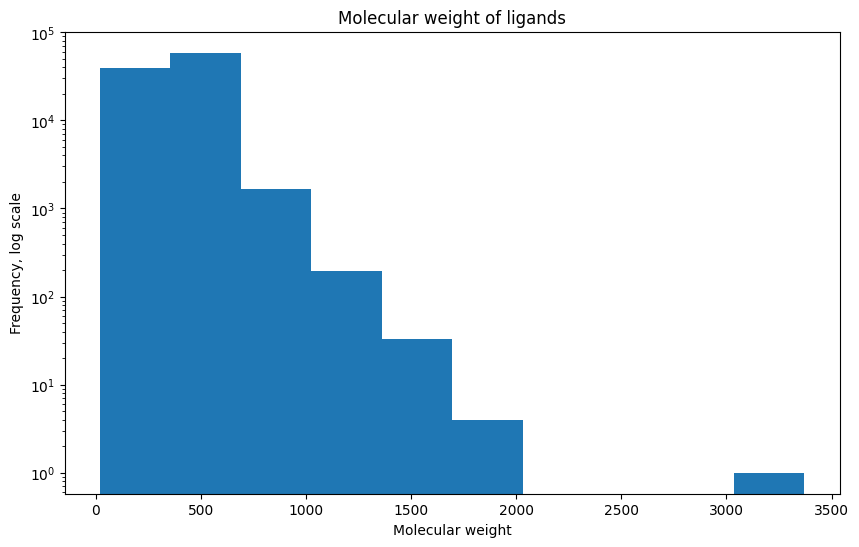

In [37]:
# 1. Molecular weight
molecular_weights = []

for molecule in df_subset['RDKIT Molecules']:
    start_time = time.time()
    mw = Descriptors.MolWt(molecule)   
    molecular_weights.append(mw) 
    end_time = time.time()
    execution_times.append(end_time - start_time)

# Calculer les statistiques
mean_time = np.mean(execution_times)
std_time = np.std(execution_times)

print(f"Mean execution time: {mean_time} seconds")
print(f"Standard deviation: {std_time} seconds")
print(f"Estimation for the full dataset: {round(len(df_bindingDB)*mean_time/60)} minutes")

# Plot
molecular_weights = pd.Series(molecular_weights)

plt.figure(figsize=(10, 6))
molecular_weights.plot(kind = 'hist', logy=True)
plt.xlabel('Molecular weight')
plt.ylabel('Frequency, log scale')
plt.title('Molecular weight of ligands')
plt.show()

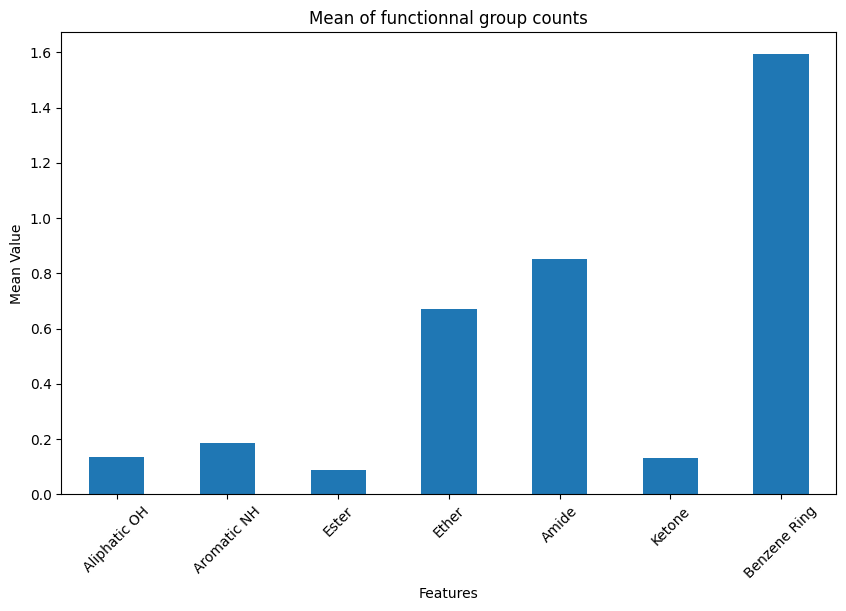

In [38]:
# 2. Functionnal group counts 

# Example SMILES list from your DataFrame
smiles_list = df_subset['Ligand SMILES']  # Assuming ligands_subset is a DataFrame

# Calculate functional group counts for each molecule
results = []
for smiles in smiles_list:
    molecule = Chem.MolFromSmiles(smiles)
    if molecule:
        counts = {
            "SMILES": smiles,
            "Aliphatic OH": Fragments.fr_Al_OH(molecule),
            "Aromatic NH": Fragments.fr_Ar_NH(molecule),
            "Ester": Fragments.fr_ester(molecule),
            "Ether": Fragments.fr_ether(molecule),
            "Amide": Fragments.fr_amide(molecule),
            "Ketone": Fragments.fr_ketone(molecule),
            "Benzene Ring": Fragments.fr_benzene(molecule),
            # Add additional groups as desired
        }
        results.append(counts)

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_results.set_index('SMILES', inplace=True)
df_results.head()

# Plot 
column_means = df_results.mean()

plt.figure(figsize=(10, 6))
column_means.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean of functionnal group counts')
plt.xticks(rotation=45)
plt.show()

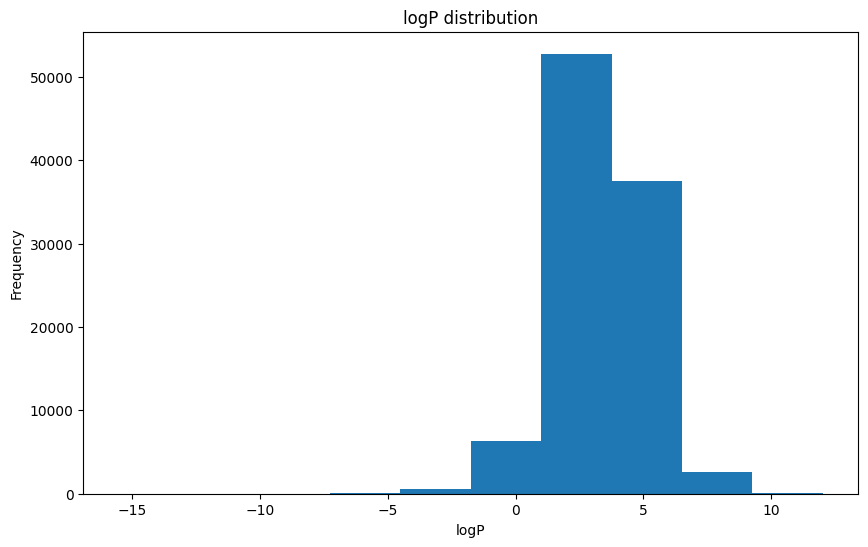

In [39]:
# 3. Hydrophobicity
df_subset['logP'] = [Descriptors.MolLogP(molecule) for molecule in df_subset['RDKIT Molecules']]

plt.figure(figsize=(10, 6))
df_subset['logP'].plot(kind='hist')
plt.xlabel('logP')
plt.ylabel('Frequency')
plt.title('logP distribution')
plt.show()

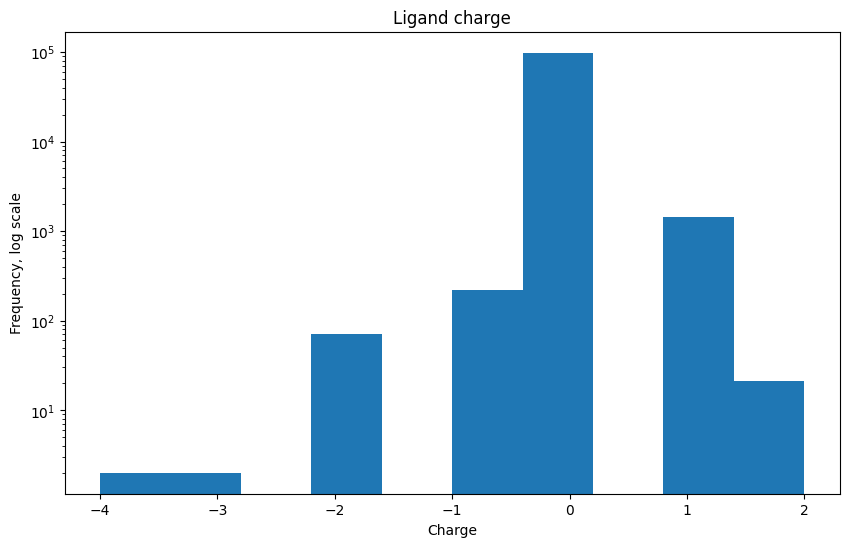

In [40]:
# 4. Charge
df_subset['Charge'] = [Chem.GetFormalCharge(molecule) for molecule in df_subset['RDKIT Molecules']]

plt.figure(figsize=(10, 6))
df_subset['Charge'].plot(kind='hist', logy=True)
plt.xlabel('Charge')
plt.ylabel('Frequency, log scale')
plt.title('Ligand charge')
plt.show()

### 2. Characterization of the ligands of a defined target

## 4. Characterization via embeddings

### 1. Characterization of all the ligands of the family

In [65]:
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [ ]:
# Import required libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm
# Step 1: Calculate molecular descriptors
def calculate_descriptors(molecule):
    """Calculate key molecular descriptors for a molecule"""
    descriptors = {}
    
    # Calculate all descriptors
    all_descriptors = getMolDescriptors(molecule)
    
    
    return all_descriptors

# Calculate descriptors for all molecules
descriptor_data = []
for mol in tqdm(df_subset['RDKIT Molecules'].dropna()):
    descriptor_data.append(calculate_descriptors(mol))

# Convert to DataFrame
descriptor_df = pd.DataFrame(descriptor_data)



 35%|███▌      | 35469/99930 [10:11<23:59, 44.79it/s]  Traceback (most recent call last):
  File "/tmp/ipykernel_101623/1417692509.py", line 10, in getMolDescriptors
    val = fn(mol)
  File "/home/sallinen/miniconda3/lib/python3.10/site-packages/rdkit/Chem/EState/EState.py", line 91, in MaxAbsEStateIndex
    return max(abs(x) for x in EStateIndices(mol, force))
  File "/home/sallinen/miniconda3/lib/python3.10/site-packages/rdkit/Chem/EState/EState.py", line -1, in EStateIndices
KeyboardInterrupt
 36%|███▌      | 36112/99930 [10:23<12:02, 88.33it/s] 

In [ ]:

# Step 2: Perform PCA
# Standardize the features
scaler = StandardScaler()
scaled_descriptors = scaler.fit_transform(descriptor_df)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_descriptors)


In [55]:
df_subset.columns

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource', 'Ki (nM)',
       'IC50 (nM)',
       ...
       'UniProt (SwissProt) Secondary ID(s) of Target Chain.12',
       'UniProt (SwissProt) Alternative ID(s) of Target Chain.12',
       'UniProt (TrEMBL) Submitted Name of Target Chain.12',
       'UniProt (TrEMBL) Entry Name of Target Chain.12',
       'UniProt (TrEMBL) Primary ID of Target Chain.12',
       'UniProt (TrEMBL) Secondary ID(s) of Target Chain.12',
       'UniProt (TrEMBL) Alternative ID(s) of Target Chain.12',
       'RDKIT Molecules', 'logP', 'Charge'],
      dtype='object', length=197)

In [57]:
# Step 3: Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, verbose=True, n_iter=250, n_jobs=12)
tsne_result = tsne.fit_transform(scaled_descriptors)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 99930 samples in 0.126s...
[t-SNE] Computed neighbors for 99930 samples in 13.232s...
[t-SNE] Computed conditional probabilities for sample 1000 / 99930
[t-SNE] Computed conditional probabilities for sample 2000 / 99930
[t-SNE] Computed conditional probabilities for sample 3000 / 99930
[t-SNE] Computed conditional probabilities for sample 4000 / 99930
[t-SNE] Computed conditional probabilities for sample 5000 / 99930
[t-SNE] Computed conditional probabilities for sample 6000 / 99930
[t-SNE] Computed conditional probabilities for sample 7000 / 99930
[t-SNE] Computed conditional probabilities for sample 8000 / 99930
[t-SNE] Computed conditional probabilities for sample 9000 / 99930
[t-SNE] Computed conditional probabilities for sample 10000 / 99930
[t-SNE] Computed conditional probabilities for sample 11000 / 99930
[t-SNE] Computed conditional probabilities for sample 12000 / 99930
[t-SNE] Computed conditional probabilities for sa

PCA explained variance ratio: [0.44683909 0.24268853]


/tmp/ipykernel_101623/4249747871.py:11: UserWarning: Mismatched number of handles and labels: len(handles) = 13 len(labels) = 2178
  ax1.legend(handles=scatter1.legend_elements()[0], labels=family_dict.keys(), title='Target Family')
/tmp/ipykernel_101623/4249747871.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/sallinen/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


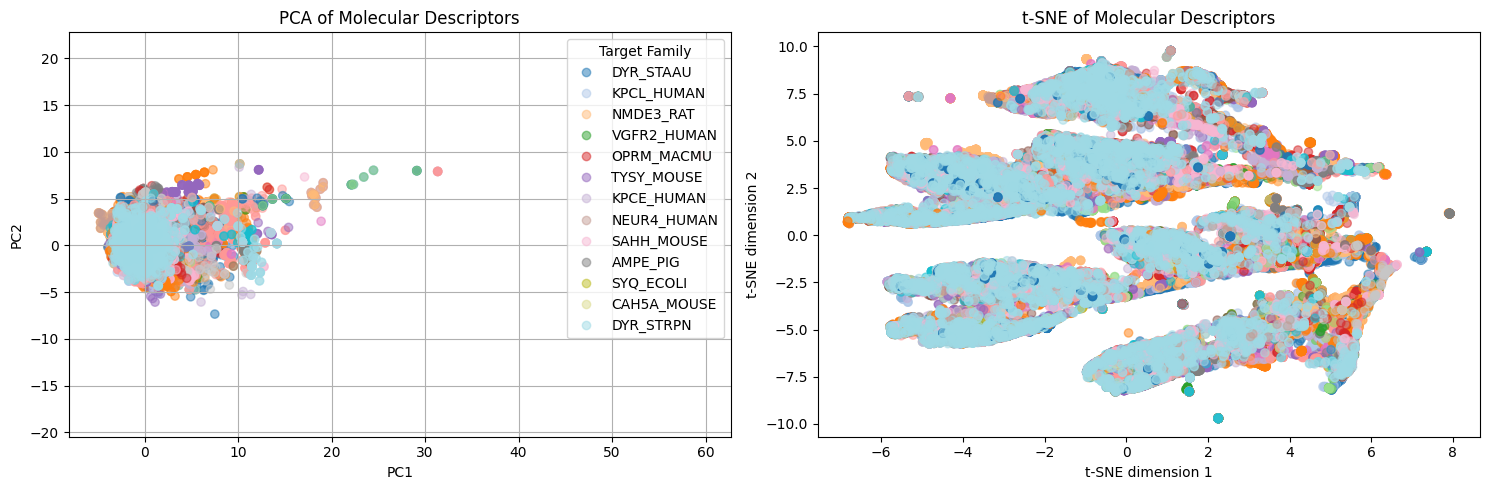

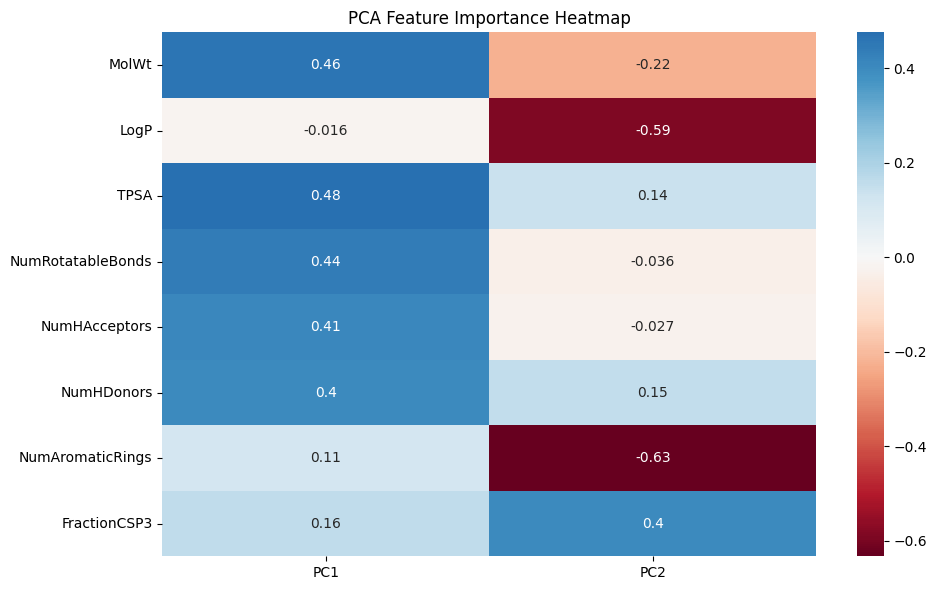

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

print(f'PCA explained variance ratio: {pca.explained_variance_ratio_}')
# Plot PCA results, color by target name
# Assign each target name a colour (integer)
colour_dict = {name: i for i, name in enumerate(df_subset['Target Name'].unique())}
scatter1 = ax1.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c=df_subset['Target Name'].map(colour_dict), cmap='tab20')
ax1.set_title('PCA of Molecular Descriptors')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.legend(handles=scatter1.legend_elements()[0], labels=family_dict.keys(), title='Target Family')
ax1.grid()
ax1.axis('equal')

# Plot t-SNE results
scatter2 = ax2.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5, c=df_subset['Target Name'].map(colour_dict), cmap='tab20')
ax2.set_title('t-SNE of Molecular Descriptors')
ax2.set_xlabel('t-SNE dimension 1')
ax2.set_ylabel('t-SNE dimension 2')

plt.tight_layout()
plt.show()

# Additional analysis: Feature importance in PCA
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=descriptor_df.columns
)

plt.figure(figsize=(10, 6))
sns.heatmap(feature_importance, annot=True, cmap='RdBu', center=0)
plt.title('PCA Feature Importance Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
#Plot seperately the points having the same target
#TODO : define labels
## PCA

fig, axes = plt.subplots(1, len(family_dict), figsize=(15, 5), sharex=True, sharey=True)
for ax, label in zip(axes, family_dict.keys()):
    mask = df_subset['Target Name'] == label
    scatter = ax.scatter(pca_result[mask, 0], pca_result[mask, 1], alpha=0.5, c=df_subset['Target Name'][mask].map(colour_dict), cmap='tab20')
    ax.set_title(f'PCA of {label}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid()
    ax.axis('equal')

plt.tight_layout()
plt.show()

## t-SNE
# Create subplots for t-SNE results
fig, axes = plt.subplots(1, len(family_dict), figsize=(15, 5), sharex=True, sharey=True)

# Plot t-SNE results in each subplot
for ax, label in zip(axes, family_dict.keys()):
    mask = df_subset['Target Name'] == label
    scatter = ax.scatter(tsne_result[mask, 0], tsne_result[mask, 1], alpha=0.5, c=df_subset['Target Name'][mask].map(colour_dict), cmap='tab20')
    ax.set_title(f't-SNE of {label}')
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.grid()
    ax.axis('equal')

plt.tight_layout()
plt.show()

In [ ]:
pca_data = list(zip(pca_result[:, 0], pca_result[:, 1]))
tsne_data = list(zip(tsne_result[:, 0], tsne_result[:, 1]))

### Evaluation of the clustering

In [ ]:
# Perform K-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import mode

In [ ]:
## PCA
pca_kmeans = KMeans(n_clusters=3, random_state=0)#TODO : best number of clusters based on the silhouette
pca_kmeans.fit(pca_data)

# Get the cluster labels
pca_labels = pca_kmeans.labels_
pca_centers = pca_kmeans.cluster_centers_

#Visualize the clustering results
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=pca_labels, cmap='viridis')
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', marker='x')
plt.title('K-means Clustering on PCA')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
## tsne
tsne_kmeans = KMeans(n_clusters=3, random_state=0)#TODO : best number of clusters based on the silhouette
tsne_kmeans.fit(tsne_data)

# Get the cluster labels
tsne_labels = tsne_kmeans.labels_
tsne_centers = tsne_kmeans.cluster_centers_

#Visualize the clustering results
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=tsne_labels, cmap='viridis')
plt.scatter(tsne_centers[:, 0], tsne_centers[:, 1], c='red', marker='x')
plt.title('K-means Clustering tsne')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
# silhouette of the found clusters
pca_silhouette_avg = silhouette_score(pca_data, pca_labels)
print(f'Silhouette Score: {pca_silhouette_avg}')

tsne_silhouette_avg = silhouette_score(tsne_data, tsne_labels)
print(f'Silhouette Score: {tsne_silhouette_avg}')

In [ ]:
def calculate_purity(cluster_labels, true_labels):
    clusters = np.unique(cluster_labels)
    majority_sum = 0
    for cluster in clusters:
        true_labels_in_cluster = true_labels[cluster_labels == cluster]
        majority_label = mode(true_labels_in_cluster)[0][0]
        majority_sum += np.sum(true_labels_in_cluster == majority_label)
    purity = majority_sum / len(true_labels)
    return purity

In [ ]:
# purity of the clusters based on ground truth labels
true_labels = df_subset['Target Name']

pca_purity = calculate_purity(pca_labels, true_labels)
print(f'Purity PCA: {pca_purity}')

tsne_purity = calculate_purity(tsne_labels, true_labels)
print(f'Purity PCA: {tsne_purity}')

### 2. Characterization of the ligands of a defined target

## 5. ML inference and comparison